In [1]:
import numpy as np
import pandas as pd
#!pip install torch
import torch as t
import torch.nn as nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('../data/compas-scores-two-years.csv')

In [3]:
df1=df[["sex","age_cat",'decile_score','priors_count','days_b_screening_arrest', 'c_jail_in', 'c_jail_out','c_charge_degree','is_recid','score_text',"race", 'two_year_recid']]
df1=df1[(df1['days_b_screening_arrest'] <= 30)|(df1['days_b_screening_arrest'] >= -30)]
df1=df1[df1['is_recid'] != -1]
df1=df1[df1['c_charge_degree'] != "O"]
df1=df1[df1['score_text'] != 'N/A']

df1['length_of_stay']=df1['c_jail_out'].apply(pd.to_datetime) - df1['c_jail_in'].apply(pd.to_datetime)
df1['length_of_stay']=df1['length_of_stay'].dt.days
df1['length_of_stay'] = df1.length_of_stay.apply(lambda x:'greater than 100 days'  if x >100 else ('10-100 days' if x >10 else 'less than 10 days'))

df1=df1[(df1['race'] == 'Caucasian') | (df1['race'] == 'African-American')]
df1.loc[df1.race=='Caucasian','race']=1
df1.loc[df1.race=='African-American','race']=0

categorical_variabls = ["c_charge_degree","race","sex","age_cat","score_text",'is_recid','two_year_recid','length_of_stay']
for var in categorical_variabls:
    df1[var] = df1[var].astype('category').cat.codes
    
df1=df1[["sex","age_cat",'decile_score','priors_count','days_b_screening_arrest','c_charge_degree','is_recid','score_text','length_of_stay',"race", 'two_year_recid']]

In [4]:
df1.groupby(['race', 'two_year_recid'])['sex'].agg([ 'count'])

count
race two_year_recid       
0    0                1668
     1                1869
1    0                1421
     1                 957

In [5]:
df_a=df1[(df1['race'] == 0)]
del df_a['race']
df_c=df1[(df1['race'] == 1)]
del df_c['race']
df_a.head()

,sex,age_cat,decile_score,priors_count,days_b_screening_arrest,c_charge_degree,is_recid,score_text,length_of_stay,two_year_recid
1,1,0,3,0,-1.0,0,1,1,2,1
2,1,2,4,4,-1.0,0,1,1,2,1
11,1,2,6,3,0.0,1,1,2,2,1
13,1,0,4,0,-1.0,0,0,1,2,0
15,1,0,3,7,22.0,0,1,1,2,1


In [6]:
#split dataset so that training:validation:testing=5:1:1

X_a = df_a.drop(columns = ['two_year_recid']).copy()
y_a = df_a['two_year_recid']

df_a_X_train, df_a_X_rem, df_a_y_train, df_a_y_rem = train_test_split(X_a,y_a, train_size=5/7.0)
df_a_X_valid, df_a_X_test, df_a_y_valid, df_a_y_test = train_test_split(df_a_X_rem,df_a_y_rem, test_size=0.5)

X_c = df_c.drop(columns = ['two_year_recid']).copy()
y_c = df_c['two_year_recid']

df_c_X_train, df_c_X_rem, df_c_y_train, df_c_y_rem = train_test_split(X_c,y_c, train_size=5/7.0)
df_c_X_valid, df_c_X_test, df_c_y_valid, df_c_y_test = train_test_split(df_c_X_rem,df_c_y_rem, test_size=0.5)

X_train=pd.concat([df_a_X_train,df_c_X_train])
y_train=pd.concat([df_a_y_train,df_c_y_train])
X_valid=pd.concat([df_a_X_valid,df_c_X_valid])
y_valid=pd.concat([df_a_y_valid,df_c_y_valid])
X_test=pd.concat([df_a_X_test,df_c_X_test])
y_test=pd.concat([df_a_y_test,df_c_y_test])


Baseline Model: Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression as logr
from sklearn.metrics import accuracy_score 
clr=logr(random_state=0,max_iter=1000).fit(X_train, y_train)
clr_a = logr(random_state=0,max_iter=1000).fit(df_a_X_train, df_a_y_train)
clr_c = logr(random_state=0,max_iter=1000).fit(df_c_X_train, df_c_y_train)

#validation acc
result= clr.score(X_valid, y_valid)
print("Accuracy: %.3f%%" % (result*100.0))
result_a = clr_a.score(df_a_X_valid, df_a_y_valid)
print("Accuracy: %.3f%%" % (result_a*100.0))
result_c = clr_c.score(df_c_X_valid, df_c_y_valid)
print("Accuracy: %.3f%%" % (result_c*100.0))
calibration=abs(result_a-result_c)
print("Calibration: %.3f%%" % (calibration*100.0))

#test acc
predict=clr.predict(X_test)
a=accuracy_score(y_test,predict)
print("Accuracy: %.3f%%" % (a*100.0))
predict_a = clr_a.predict(df_a_X_test)
a_a=accuracy_score(df_a_y_test,predict_a)
print("Accuracy: %.3f%%" % (a_a*100.0))
predict_c = clr_c.predict(df_c_X_test)
a_c=accuracy_score(df_c_y_test,predict_c)
print("Accuracy: %.3f%%" % (a_c*100.0))
calibration2=abs(a_a-a_c)
print("Calibration: %.3f%%" % (calibration2*100.0))


Accuracy: 96.331%
Accuracy: 95.842%
Accuracy: 97.059%
Calibration: 1.217%
Accuracy: 97.163%
Accuracy: 96.443%
Accuracy: 98.235%
Calibration: 1.793%


In [8]:
#Logistic refression with PR
class LogisticRegression(nn.Module):
    def __init__(self,df):
        super(LogisticRegression, self).__init__()
        self.w = nn.Linear(df.shape[1], out_features=1, bias=True)
        self.sigmod = nn.Sigmoid()
    def forward(self,x):
        w = self.w(x)
        output = self.sigmod(w)
        return output

In [9]:
class PRLoss():#using linear
    def __init__(self, eta=1.0):
        super(PRLoss, self).__init__()
        self.eta = eta
    def forward(self,output_c,output_a):
        # For the mutual information, 
        # eqn(9): Pr[y|s] = sum{(xi,si),si=s} sigma(xi,s) / D[xs]
        #D[xs]
        N_cau = t.tensor(output_c.shape[0])
        N_aa   = t.tensor(output_a.shape[0])
        Dxisi = t.stack((N_aa,N_cau),axis=0) #male sample, #female sample
        # Pr[y|s]
        y_pred_cau = t.sum(output_c)
        y_pred_aa   = t.sum(output_a)
        P_ys = t.stack((y_pred_aa,y_pred_cau),axis=0) / Dxisi
        # eqn(10): Pr[y]~sum{(xi,si)} sigma(xi,si) / |D[xs]|
        P = t.cat((output_c,output_a),0)
        P_y = t.sum(P) / (df_c_X_train.shape[0]+df_a_X_train.shape[0])
        # P(siyi)
        P_s1y1 = t.log(P_ys[1]) - t.log(P_y)
        P_s1y0 = t.log(1-P_ys[1]) - t.log(1-P_y)
        P_s0y1 = t.log(P_ys[0]) - t.log(P_y)
        P_s0y0 = t.log(1-P_ys[0]) - t.log(1-P_y)
        # eqn(11) RPR
        # PI=sum{xi,si}sum{y}M*ln(Pr[y|si]/Pr[y])=sum{xi,si}sum{y}M*ln(Pr[Y,S]/(Pr[S]pR[Y]))
        PI_s1y1 = output_c * P_s1y1
        PI_s1y0 =(1- output_c) * P_s1y0
        PI_s0y1 = output_a * P_s0y1
        PI_s0y0 = (1- output_a )* P_s0y0
        PI = t.sum(PI_s1y1) + t.sum(PI_s1y0) + t.sum(PI_s0y1) + t.sum(PI_s0y0)
        PI = self.eta * PI
        return PI

In [10]:
class PRLR():
    def __init__(self, eta=0.0,epochs = 3000,lr = 0.01):
        super(PRLR, self).__init__()
        self.eta = eta
        self.epochs = epochs
        self.lr = lr
    def fit(self,df_c_X_train,df_c_y_train,df_a_X_train,df_a_y_train):
        model_c = LogisticRegression(df_c_X_train)
        model_a = LogisticRegression(df_a_X_train)
        criterion = nn.BCELoss(reduction='sum')
        PI = PRLoss(eta=self.eta)
        epochs = self.epochs
        optimizer = t.optim.Adam(list(model_c.parameters())+ list(model_a.parameters()), self.lr, weight_decay=1e-5)
        for epoch in range(epochs):
            optimizer.zero_grad()
            output_c = model_c(df_c_X_train)
            output_a = model_a(df_a_X_train)
            logloss = criterion(output_c, df_c_y_train)+ criterion(output_a, df_a_y_train)
            PIloss = PI.forward(output_c,output_a)
            loss = PIloss +logloss
            loss.backward()
            optimizer.step()
            output_african_america = model_african_america(df_a_X_valid)
            output_caucasian = model_caucasian(df_c_X_valid.float())
            loglossv = criterion(output_african_america, df_a_y_valid)+ criterion(output_caucasian, df_c_y_valid)
            PIlossv = PI.forward(output_african_america,output_caucasian)
            val_loss = PI_lossv +loglossv
            val_losses.append(val_loss.item())
        model_c.eval()
        model_a.eval()
        accu = accuracy(model_c,model_a,df_c_X_train,df_c_y_train,df_a_X_train,df_a_y_train)
        #cvs = CVS(model_c,model_a,df_c_X_train, df_a_X_train)
        return accu#,cvs

In [16]:
df_c_X_train=t.tensor(np.array(df_c_X_train)).to(t.float32)
df_c_y_train=t.from_numpy(np.array(df_c_y_train).astype('float32')).reshape(df_c_X_train.shape[0],1)
df_a_X_train=t.tensor(np.array(df_a_X_train)).to(t.float32)
df_a_y_train=t.from_numpy(np.array(df_a_y_train).astype('float32')).reshape(df_a_X_train.shape[0],1)

df_c_X_valid=t.tensor(np.array(df_c_X_valid)).to(t.float32)
df_c_y_valid=t.from_numpy(np.array(df_c_y_valid).astype('float32')).reshape(df_c_X_valid.shape[0],1)
df_a_X_valid=t.tensor(np.array(df_a_X_valid)).to(t.float32)
df_a_y_valid=t.from_numpy(np.array(df_a_y_valid).astype('float32')).reshape(df_a_X_valid.shape[0],1)

df_c_X_test=t.tensor(np.array(df_c_X_test)).to(t.float32)
df_c_y_test=t.from_numpy(np.array(df_c_y_test).astype('float32')).reshape(df_c_X_test.shape[0],1)
df_a_X_test=t.tensor(np.array(df_a_X_test)).to(t.float32)
df_a_y_test=t.from_numpy(np.array(df_a_y_test).astype('float32')).reshape(df_a_X_test.shape[0],1)

def accuracy( Model_c,Model_a, df_c_X_train,df_c_y_train,df_a_X_train,df_a_y_train):
    yc_pred = (Model_c(df_c_X_train) >= 0.5)
    ya_pred = (Model_a(df_a_X_train) >= 0.5)
    accu_c  = t.sum(yc_pred.flatten() == df_c_y_train.flatten()) / df_c_X_train.shape[0]
    accu_a  = t.sum(ya_pred.flatten() == df_a_y_train.flatten()) / df_a_X_train.shape[0]
    accuracy = (accu_c + accu_a) / 2
    calibration=abs(accu_c-accu_a)
    return round(accuracy.item(),4),round(calibration.item(),4)
    print("Accuracy : %.3f" % (accuracy * 100)+'%')
    print("Calibration : %.3f" % (calibration * 100)+'%')

eta_value = [0.0,1.0,2.0,3.0,4.0,5.0,10.0,15.0,20.0,25.0]
PR = PRLR(eta = 0.0, epochs = 3000, lr = 0.01)
accur = t.tensor(PR.fit(df_c_X_train,df_c_y_train,df_a_X_train,df_a_y_train)).reshape(2,1)
accurv = t.tensor(PR.fit(df_c_X_valid,df_c_y_valid,df_a_X_valid,df_a_y_valid)).reshape(2,1)

for e in range(1,len(eta_value)):
    PR = PRLR(eta = eta_value[e], epochs = 3000, lr = 0.01)
    accu2 = t.tensor(PR.fit(df_c_X_train,df_c_y_train,df_a_X_train,df_a_y_train)).reshape(2,1)
    accuv2=t.tensor(PR.fit(df_c_X_valid,df_c_y_valid,df_a_X_valid,df_a_y_valid)).reshape(2,1)
    accur = t.cat((accur,accu2),1)
    accurv=t.cat((accurv,accuv2),1)


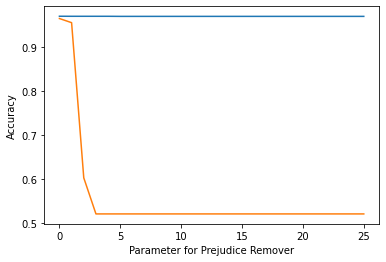

In [19]:
eta_accu = accur[0].tolist()
eta_accuv = accurv[0].tolist()
plt.plot(eta_value,eta_accu)
plt.plot(eta_value,eta_accuv)
plt.xlabel('Parameter for Prejudice Remover')
plt.ylabel('Accuracy')
plt.show()

In [22]:
#eta=1
accur[0][1]

tensor(0.9696)

In [23]:
#eta=1
accurv[0][1]

tensor(0.9551)

In [30]:
eta_calc=accurv[1].tolist()
eta_calc[1]

0.025100000202655792

In [24]:
model_c = LogisticRegression(df_c_X_train)
model_a = LogisticRegression(df_a_X_train)
pr_accu=accuracy(model_c,model_a, df_c_X_test,df_c_y_test,df_a_X_test,df_a_y_test)


In [25]:
#accuracy calibration
pr_accu

(0.5579, 0.0842)